## n-step Bootstrapping

## 构造环境

In [198]:
import random
import numpy as np

class Env():                   
    '''构造一个环境类'''        
    def __init__(self, num_states=19):  
        self.STATES = np.arange(1, num_states + 1)
        self.Terminal = [0, num_states + 1]
        self.START_STATE = (1 + num_states) // 2   # 19 to 10
        self.left, self.right = 0, 1
        self.action_space = [self.left, self.right]
        self.nS = num_states + 2   # 加上Terminal的两个状态即21个状态
        self.nA = 2
        self.state = self.START_STATE
        
    def reset(self):
        self.state = self.START_STATE
        return self.state
    
    def sample_action(self):
        '''等概率选择动作'''
        if random.random() > 0.5:
            return self.left
        else:
            return self.right
        
    def step(self, action):
        if self.state in self.Terminal: 
            self.state = self.START_STATE
        done = False
        reward = 0
        # left-action
        if action == self.left:
            self.state -= 1
            if self.state in self.Terminal: 
                done = True
                reward = -1
        # right-action
        else:
            self.state += 1
            if self.state in self.Terminal:
                done = True
                reward = 1
        return self.state, reward, done

- 环境初探

In [89]:
env = Env()
env.reset()
print(env.state)
for _ in range(12):
    print(env.step( env.sample_action() ))

10
(9, 0, False)
(10, 0, False)
(11, 0, False)
(10, 0, False)
(9, 0, False)
(8, 0, False)
(7, 0, False)
(8, 0, False)
(9, 0, False)
(8, 0, False)
(9, 0, False)
(10, 0, False)


## 1. n-step TD Prediction

In [128]:
import random

def n_step_TD_prediction(env, n=4, alpha=0.4, num_of_episode=10, gamma=1):
    '''n-step TD预测,返回state value表'''
    # 1.Init V(S)
    value = np.zeros(env.nS)
    for episode in range(num_of_episode):
        env.reset()
        # 1.1 Init S_set and R_set and store S0 and R0  
        state_lst = [env.START_STATE]
        reward_lst = [0]
        # 总时间步(火车头)
        t = 0  
        T = float('inf')
        while True:
            t += 1
            # 2.采样并存储所有时间步下的reward和state
            if t < T:
                # 2.1 等概率采样并执行动作,得到下一步信息
                action = env.sample_action()
                next_state, reward, done = env.step(action)
                # 2.2 存储next_state和reward
                reward_lst.append(reward)
                state_lst.append(next_state)
                # 2.3 探索到terminal状态后就不再采样动作,第2部分代码块不会再执行
                if done: 
                    T = t
            # 更新时间步(火车尾)
            update_t = t - n
            # 3.计算n-step内的累计reward和V(St+n)得到的回报returns，然后更新V(St)
            if update_t >= 0:
                returns = 0
                # 3.1 计算n-step之间的累计reward
                for time in range( update_t + 1, min(update_t + n, T) + 1 ):
                    returns += gamma**(time - update_t - 1) * reward_lst[time]
                # 3.2 与V(St+n)累加得到完整returns
                if update_t + n < T:
                    returns += gamma**n * value[ state_lst[update_t + n] ]
                # 3.3 更新V(St)
                value[ state_lst[update_t] ] += alpha * (returns - value[ state_lst[update_t] ])
            # 更新到terminal前一步则退出循环
            if update_t == T - 1:
                break
    return value

In [129]:
env = Env(19)
value = n_step_TD_prediction(env, n=4, alpha=0.4, num_of_episode=10, gamma=1)
value

array([ 0.        , -0.28578015, -0.95272824, -0.93574355, -0.68421197,
       -0.45733527, -0.09219285, -0.25670195, -0.09060562,  0.01690559,
        0.1421116 ,  0.21173151,  0.25505695,  0.42496575,  0.51888794,
        0.65512181,  0.75683963,  0.84831008,  0.97383755,  0.8566696 ,
        0.        ])

### 1.1 绘图   

In [177]:
def get_average_error(env):
    TRUE_VALUE = np.arange(-20, 22, 2) / 20.0
    TRUE_VALUE[0] = TRUE_VALUE[-1] = 0
    
    steps = np.power(2, np.arange(0, 10))
    alphas = np.arange(0, 1.1, 0.1)
    num_of_episode = 10
    runs = 100
    gamma = 1
    
    errors = np.zeros( (len(steps), len(alphas)) )
    for run in range(runs):
        for step_i, n in enumerate(steps):
            for alpha_i, alpha in enumerate(alphas):
                value = n_step_TD_prediction(env, n, alpha, num_of_episode, gamma)
                errors[step_i, alpha_i] += np.sqrt(np.sum(np.power(value - TRUE_VALUE, 2)) / 19)
        print("\r" + "#"*round((int(run)+1)/runs*60) + " "*(60-round((int(run)+1)/runs-1)) + '|' + str(int(run)+1) + '/' + str(runs), sep="", end="")
    errors /= runs
    return errors

errors = get_average_error(env)

############################################################                                                            |100/100

<IPython.core.display.Javascript object>


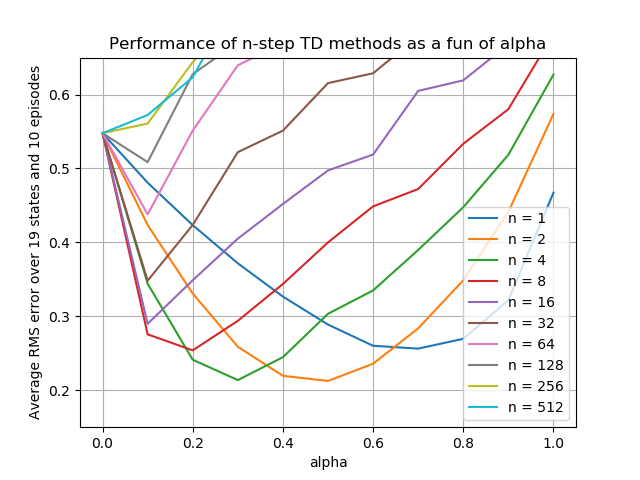

In [179]:
def show(errors):
    steps = np.power(2, np.arange(0, 10))
    alphas = np.arange(0, 1.1, 0.1)
    for i in range(0, len(steps)):
        plt.plot(alphas, errors[i, :], label='n = %d' % (steps[i]))
    plt.xlabel('alpha')
    plt.ylabel('Average RMS error over 19 states and 10 episodes')
    plt.ylim([0.15, 0.65])
    plt.title('Performance of n-step TD methods as a fun of alpha')
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()

show(errors)

## 2. n-step On-policy TD Control via Sarsa

In [214]:
import random

def select_action_behavior_policy(action_value_set, epsilon):
    '''使用epsilon-greedy采样action'''
    prob = random.random()
    if prob > epsilon:  action = np.argmax(action_value_set)
    else:  action = random.randint(0,1)
    return action

def n_step_Sarsa(env, n=4, alpha=0.4, epsilon_scope=[0.2,0.05,0.99], num_of_episode=10, gamma=1):
    '''n-step Sarsa control,返回Q表'''
    epsilon = epsilon_scope[0]
    # 1.Init Q(s,a)
    Q = np.zeros( (env.nS, env.nA) )
    for _ in range(num_of_episode):
        env.reset()
        # 1.1 Init S_set, A_set and R_set and store S0, A0 and R0  
        state_lst = [env.START_STATE]
        reward_lst = [0]
        action = select_action_behavior_policy( Q[env.START_STATE], epsilon )
        action_lst = [action]
        # 总时间步(火车头)
        t = 0  
        T = float('inf')
        while True:
            t += 1
            # 2.采样并存储所有时间步下的reward和state
            if t < T:
                # 2.1 执行动作,得到下一步信息
                next_state, reward, done = env.step(action)
                # 2.2 存储next_state和reward
                reward_lst.append(reward)
                state_lst.append(next_state)
                # 2.3 采样下一步动作,若探索到terminal状态后则不再采样动作,第2部分代码块不会再执行
                if done: T = t
                else:
                    action = select_action_behavior_policy( Q[next_state], epsilon )
                    action_lst.append(action)
            # 更新时间步(火车尾)
            update_t = t - n
            # 3.计算n-step内的累计reward和Q(Sτ+n,Aτ+n)得到的回报returns，然后更新Q(Sτ,Aτ)
            if update_t >= 0:
                returns = 0
                # 3.1 计算n-step之间的累计reward
                for time in range( update_t + 1, min(update_t + n, T) + 1 ):
                    returns += gamma**(time - update_t - 1) * reward_lst[time]
                # 3.2 与Q(Sτ+n,Aτ+n)累加得到完整returns
                if update_t + n < T:
                    returns += gamma**n * Q[state_lst[update_t + n]][action_lst[update_t + n]]
                # 3.3 更新Q(Sτ,Aτ)
                Q[state_lst[update_t]][action_lst[update_t]] += alpha * (returns - Q[state_lst[update_t]][action_lst[update_t]])
            # 更新到terminal前一步则退出循环
            if update_t == T - 1:
                break
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
    return Q

In [242]:
start = time()
env = Env(19)
Q_table = n_step_Sarsa(env, n=4, alpha=0.4, epsilon_scope=[0.2,0.05,0.99], num_of_episode=100, gamma=1)
print(time()-start)
Q_table

0.03224825859069824


array([[ 0.00000000e+00,  0.00000000e+00],
       [-4.00000000e-01, -2.30400000e-02],
       [-2.40000000e-01, -2.40000000e-01],
       [-2.40000000e-01, -3.45600000e-02],
       [-1.53600000e-01, -3.68640000e-02],
       [-8.29440000e-03, -1.99065600e-03],
       [-8.84736000e-03, -1.27401984e-03],
       [-4.08960369e-04, -1.83458857e-04],
       [-1.35895450e-03,  3.57197336e-01],
       [ 2.39092779e-01,  8.84918955e-01],
       [ 8.58472992e-01,  9.99927583e-01],
       [ 9.65091012e-01,  9.99865806e-01],
       [ 9.91747902e-01,  9.99970359e-01],
       [ 9.11923615e-01,  9.97033710e-01],
       [ 9.92373469e-01,  1.00000000e+00],
       [ 9.96557239e-01,  9.68994206e-01],
       [ 8.70399995e-01,  1.00000000e+00],
       [ 9.68634709e-01,  1.00000000e+00],
       [ 9.40896427e-01,  1.00000000e+00],
       [ 9.53491308e-01,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00]])

## 3. n-step On-policy TD Control via Expected Sarsa

In [243]:
import random

def select_action_behavior_policy(action_value_set, epsilon):
    '''使用epsilon-greedy采样action'''
    prob = random.random()
    if prob > epsilon:  action = np.argmax(action_value_set)
    else:  action = random.randint(0,1)
    return action

def policy(action_value_set, action, epsilon=0.2):
    '''返回当前state下选择该action的概率'''
    best_action = np.argmax(action_value_set)
    if best_action == action:
        return 1 - epsilon
    return epsilon

def n_step_Expected_Sarsa(env, n=4, alpha=0.4, epsilon_scope=[0.2,0.05,0.99], num_of_episode=10, gamma=1):
    '''n-step Sarsa control,返回Q表'''
    epsilon = epsilon_scope[0]
    # 1.Init Q(s,a)
    Q = np.zeros( (env.nS, env.nA) )
    for _ in range(num_of_episode):
        env.reset()
        # 1.1 Init S_set, A_set and R_set and store S0, A0 and R0  
        state_lst = [env.START_STATE]
        reward_lst = [0]
        action = select_action_behavior_policy( Q[env.START_STATE], epsilon )
        action_lst = [action]
        # 总时间步(火车头)
        t = 0  
        T = float('inf')
        while True:
            t += 1
            # 2.采样并存储所有时间步下的reward和state
            if t < T:
                # 2.1 执行动作,得到下一步信息
                next_state, reward, done = env.step(action)
                # 2.2 存储next_state和reward
                reward_lst.append(reward)
                state_lst.append(next_state)
                # 2.3 采样下一步动作,若探索到terminal状态后则不再采样动作,第2部分代码块不会再执行
                if done: T = t
                else:
                    action = select_action_behavior_policy( Q[next_state], epsilon )
                    action_lst.append(action)
            # 更新时间步(火车尾)
            update_t = t - n
            # 3.计算n-step内的累计reward和Q(Sτ+n,Aτ+n)得到的回报returns，然后更新Q(Sτ,Aτ)
            if update_t >= 0:
                returns = 0
                # 3.1 计算n-step之间的累计reward
                for time in range( update_t + 1, min(update_t + n, T) + 1 ):
                    returns += gamma**(time - update_t - 1) * reward_lst[time]
                # 3.2 与Q(Sτ+n,Aτ+n)累加得到完整returns
                if update_t + n < T:
                    # expect = ∑_{a}.π(a|St+n).Q(St+n,a)
                    expect = 0
                    for act in env.action_space:
                        expect += policy(Q[next_state],act,epsilon) * Q[next_state][act]
                    returns += gamma**n * expect
                # 3.3 更新Q(Sτ,Aτ)
                Q[state_lst[update_t]][action_lst[update_t]] += alpha * (returns - Q[state_lst[update_t]][action_lst[update_t]])
            # 更新到terminal前一步则退出循环
            if update_t == T - 1:
                break
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
    return Q

In [244]:
start = time()
env = Env(19)
Q_table = n_step_Expected_Sarsa(env, n=4, alpha=0.4, epsilon_scope=[0.2,0.05,0.99], num_of_episode=100, gamma=1)
print(time()-start)
Q_table

0.021123886108398438


array([[ 0.00000000e+00,  0.00000000e+00],
       [-4.00000000e-01,  0.00000000e+00],
       [-4.00000000e-01,  0.00000000e+00],
       [-4.00000000e-01, -2.50905600e-03],
       [-1.65517056e-01, -2.73070327e-02],
       [-2.15170560e-02,  0.00000000e+00],
       [-3.16800000e-02, -2.50905600e-03],
       [-3.16800000e-02, -3.76608104e-04],
       [-1.51274663e-02, -2.71827052e-03],
       [-1.35497143e-03,  8.12701698e-01],
       [ 8.01074891e-01,  9.82397659e-01],
       [ 9.30763292e-01,  9.95941072e-01],
       [ 7.36448304e-01,  9.91741459e-01],
       [ 8.08013628e-01,  9.98479266e-01],
       [ 9.44476709e-01,  9.85629077e-01],
       [ 9.86262824e-01,  9.97065399e-01],
       [ 8.96992875e-01,  9.99973080e-01],
       [ 9.81755158e-01,  9.99992210e-01],
       [ 8.06874941e-01,  1.00000000e+00],
       [ 9.61004110e-01,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00]])

## 4. n-step Off-policy TD Control via Tree Backup

In [216]:
import random

def policy(action_value_set, action, epsilon=0.2):
    '''返回当前state下选择该action的概率'''
    best_action = np.argmax(action_value_set)
    if best_action == action:
        return 1 - epsilon
    return epsilon

def n_step_TreeBackup(env, n=4, alpha=0.4, epsilon_scope=[0.2,0.05,0.99], num_of_episode=10, gamma=1):
    '''n-step Sarsa control,返回Q表'''
    epsilon = epsilon_scope[0]
    # 1.Init Q(s,a)
    Q = np.zeros( (env.nS, env.nA) )
    for _ in range(num_of_episode):
        env.reset()
        # 1.1 Init S_set, A_set and R_set and store S0, A0 and R0  
        state_lst = [env.START_STATE]
        reward_lst = [0]
        # 1.2 等概率随机选择并存储A0
        action = env.sample_action()
        action_lst = [action]
        # 总时间步(火车头)
        t = 0  
        T = float('inf')
        while True:
            t += 1
            # 2.采样并存储所有时间步下的reward和state
            if t < T:
                # 2.1 执行动作,得到下一步信息
                next_state, reward, done = env.step(action)
                # 2.2 存储next_state和reward
                reward_lst.append(reward)
                state_lst.append(next_state)
                # 2.3 等概率随机采样下一步动作,若探索到terminal状态后则不再采样动作,第2部分代码块不会再执行
                if done: T = t
                else:
                    action = env.sample_action()
                    action_lst.append(action)
            # 更新时间步(火车尾)
            update_t = t - n
            # 3.计算n-step内的累计reward和Q(Sτ+n,Aτ+n)得到的回报returns，然后更新Q(Sτ,Aτ)
            if update_t >= 0:
                # 3.1 计算叶结点G_{t+n-1:t+n}
                returns = reward
                if t < T:
                    # G = Rt+1 + γ.∑_{a}.π(a|St+1).Q(St+1,a)
                    for act in env.action_space:
                        returns += gamma * policy(Q[next_state],act,epsilon) * Q[next_state][act]
                # 3.2 递归从叶结点回溯到当前节点计算出G_{t:t+n}
                for time in range( min(t, T), update_t, -1):
                    Sk = state_lst[time]
                    # expect = γ.∑_{a≠At}.π(a|Sk).Q(Sk,a) + γ.π(Ak|Sk).G 
                    expect = 0
                    for Ak in env.action_space:
                        if Ak == action:
                            # γ.π(Ak|Sk).G 
                            expect += gamma * policy(Q[Sk],action,epsilon) * returns
                        else:
                            # γ.∑_{a≠At}.π(a|Sk).Q(Sk,a)
                            expect += gamma * policy(Q[Sk],Ak,epsilon) * Q[Sk][Ak]
                    # G = Rk + γ.∑_{a≠Ak}.π(a|Sk).Q(Sk,a) + γ.π(Ak|Sk).G 
                    returns = reward_lst[time] + expect
                # 3.3 更新Q(Sτ,Aτ)
                Q[state_lst[update_t]][action_lst[update_t]] += alpha * (returns - Q[state_lst[update_t]][action_lst[update_t]])
            # 更新到terminal前一步则退出循环
            if update_t == T - 1:
                break
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
    return Q

In [234]:
from time import time

start = time()
env = Env(19)
Q_table = n_step_TreeBackup(env, n=4, alpha=0.4, epsilon_scope=[0.2,0.05,0.99], num_of_episode=100, gamma=0.9)
print(time()-start)
Q_table

0.23528194427490234


array([[ 0.00000000e+00,  0.00000000e+00],
       [-1.83187188e+00, -2.54566077e-02],
       [-1.45778956e-01, -7.32454170e-03],
       [-1.45805307e-02,  2.50279132e-03],
       [ 2.53315541e-04, -1.81829449e-03],
       [-3.40714215e-03,  2.59748790e-02],
       [ 1.63833335e-02,  3.41316081e-02],
       [ 2.28382790e-02,  6.16252053e-02],
       [ 4.56276029e-02,  8.52626751e-02],
       [ 5.18742352e-02,  1.04255929e-01],
       [ 9.20269296e-02,  1.19453713e-01],
       [ 8.46814974e-02,  1.45906541e-01],
       [ 9.96463596e-02,  1.69157853e-01],
       [ 1.26872625e-01,  1.86480153e-01],
       [ 1.80183841e-01,  3.68642681e-01],
       [ 2.38199824e-01,  5.09040793e-01],
       [ 3.88626083e-01,  6.96175368e-01],
       [ 4.41844021e-01,  8.11061611e-01],
       [ 4.11717438e-01,  9.37192277e-01],
       [ 7.10149578e-01,  1.07031985e+00],
       [ 0.00000000e+00,  0.00000000e+00]])